# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: /10pts

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions, providing the python code in the cell below.

In [34]:
df = pd.read_csv('footballer_data.csv')

# Drop the columns
columns_to_drop = [
    'ID',
    'club',
    'club_logo',
    'birth_date',
    'flag',
    'nationality',
    'photo',
    'potential'
]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Hint: In order to get dummies, you can first convert the column with strings to Categorical type using pandas,
# using a specific set of categories

columns_to_dummy = ['work_rate_att', 'work_rate_def', 'preferred_foot']

# Convert to categorical type
for column in columns_to_dummy:
    df[column] = pd.Categorical(df[column])

# Create dummy variables
df_dummies = pd.get_dummies(df[columns_to_dummy], prefix=[f"{col}_" for col in columns_to_dummy])
# Concatenate the dummy variables to the original DataFrame
df = pd.concat([df.drop(columns=columns_to_dummy), df_dummies], axis=1)



### Question 2: /10 pts

The data should all be numerical now. To evalute different models, define a function that returns the mean absolute error. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors on the original data that result if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the losses (absolute errors) and print their mean and standard deviation.

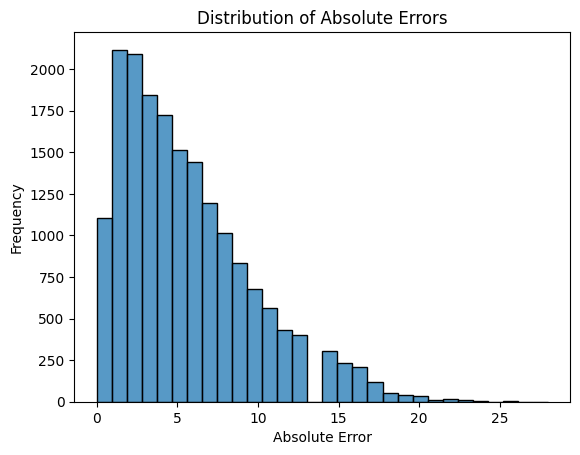

mean: 5.49133044348116
standard deviation: 4.261886186448831


In [35]:
# Define mean absolute error function  
def calculate_mae(n, y, yp):
    mae = 1/n * np.sum(abs(y-yp))

    return mae

# Get mean and std of test loss 
median_overall = df['overall'].median()
predictions = np.full(df.shape[0], median_overall)

absolute_errors = abs(df['overall'] - predictions)

# Plot distribution  
sns.histplot(absolute_errors, bins=30)
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()

mean = calculate_mae(len(predictions), df['overall'], predictions)
std_error = np.std(absolute_errors)

print(f"mean: {mean}")
print(f"standard deviation: {std_error}")

### Question 2: /15pts
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like you to choose the test set size so that the estimate of the performance of the final selected model is known to within $\pm 0.25$ units at a 95% confidence interval, using mean absolute error as the loss function of choice.

Recall that a CLT-based $95\%$ confidence interval for a mean is given by:

$ \bar{x} \pm \frac{1.96 \sigma_l}{\sqrt{n}}$,

If we equate the right hand side to $d$ and re-arrange, we can choose the test set size using the following formula, which gives the test size ($n_\mathrm{test}$) needed for a confidence interval to have width ($\pm d$) if the standard deviation of the loss is $\sigma_l$:

$ n_\textrm{test} = \left(\frac{1.96 \sigma_l}{d}\right)^2$.

Decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [36]:
# Step 1: Calculate the standard deviation of the absolute errors
std_error = np.std(absolute_errors)

# Step 2: Set the desired width of the confidence interval
d = 0.25

# Step 3: Calculate the required test size
n_test = (1.96 * std_error / d) ** 2
n_test = int(np.ceil(n_test))  # Round up to the nearest whole number

# Step 4: Split the data into features (X) and target (y)
X = df.drop(columns=['overall'])  # Features
y = df['overall']  # Target variable

# Use train_test_split to create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test/df.shape[0], random_state=42)

# Print the sizes of the training and test sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 16877
Test set size: 1117


### Question 4: /5pts
The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

In [37]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('linear_regression', LinearRegression())  # Linear regression model
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Print the coefficients of the model
print("Coefficients:", pipeline.named_steps['linear_regression'].coef_)
print("Intercept:", pipeline.named_steps['linear_regression'].intercept_)

Coefficients: [ 2.09987525e-01 -1.02452133e-02  1.67688012e-01  9.95378090e-01
  1.18020620e+00  7.60518751e-01  2.13746239e+00  1.53772442e-01
  1.65191168e+00  6.29754248e-01  6.41301967e-01  8.41564549e-02
 -9.68032858e-02 -1.47424553e-01  1.72551922e+00  9.40187186e-01
 -1.89867856e-01 -1.84406862e+00  1.26113724e-02  1.90969623e-02
 -4.46118031e-01  1.65100115e+00  4.00936874e-02 -1.68188673e-01
 -3.18277474e-01  2.03865856e+00 -1.59139416e-01 -6.84201447e-02
 -3.89848601e-02 -3.47820478e-01 -4.29550944e-01 -5.70603651e-01
 -5.42914466e-01  2.21057143e-01 -9.17063288e-01 -4.96596159e-01
 -9.45276348e-03  1.09055428e+00  3.10377826e-01  4.25749003e-01
  4.24535214e+12  2.13631338e+12  4.48395796e+12  6.70442566e+11
  5.16970601e+11  7.89419212e+11 -5.28239851e+12 -5.28239851e+12]
Intercept: 66.27354846329581


### Question 5: /15pts

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model, using your mean absolute error function from question 2.  

In [38]:
def mae_scorer(estimator, X, y):
    predictions = estimator.predict(X)
    return calculate_mae(len(predictions), y, predictions)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring=mae_scorer)

# Check if cv_scores contains any NaN values
if np.any(np.isnan(cv_scores)):
    print("Warning: Cross-validation scores contain NaN values. Check the model and data.")
else:
    # Print the cross-validation scores
    print("Cross-validation MAE scores:", cv_scores)
    print("Mean MAE:", cv_scores.mean())
    print("Standard Deviation of MAE:", cv_scores.std())

Cross-validation MAE scores: [2.84438964 1.91023348 1.84398194 1.89148343 3.3594996 ]
Mean MAE: 2.3699176192734104
Standard Deviation of MAE: 0.6198731005865077


### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. 

In [39]:
# Assuming you have already imported necessary libraries and read the data

# Create a new feature for age squared
df['age_squared'] = df['age'] ** 2

# Define features and target variable
X = df.drop(columns=['overall'])  # Drop the target variable
y = df['overall']

# Create a pipeline with polynomial features and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('poly_features', PolynomialFeatures(include_bias=False)),  # Add polynomial features
    ('linear_regression', LinearRegression())  # Linear regression model
])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert scores to positive MAE
cv_scores = -cv_scores

# Print the cross-validation scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean MAE:", cv_scores.mean())
print("Standard Deviation of MAE:", cv_scores.std())

Cross-validation MAE scores: [1.30320046 0.89763682 0.88780241 0.93294341 1.52121441]
Mean MAE: 1.1085595023561292
Standard Deviation of MAE: 0.2577720922239148


### Question 7: /10 pts


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline.  Report the cross validation score.

In [40]:
X = df.drop(columns=['overall'])  # Drop the target variable
y = df['overall']

# Create a pipeline with polynomial features (including interaction terms) and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('linear_regression', LinearRegression())  
])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert scores to positive MAE
cv_scores = -cv_scores

# Print the cross-validation scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean MAE:", cv_scores.mean())
print("Standard Deviation of MAE:", cv_scores.std())

Cross-validation MAE scores: [1.30320046 0.89763682 0.88780241 0.93294341 1.52121441]
Mean MAE: 1.1085595023561292
Standard Deviation of MAE: 0.2577720922239148


### Question 8: /10pts

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Explain why.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

YOUR ARGUMENT HERE 

Adding a cubic term to the model will reduce the mean absolute error for the training model but will also cause overfitting. So even thought the training data will have less error, the test data will have more error. The model may become overly sensitive to fluctiations in the training data rather than the underlying patters.

Sincerly,

Junior Data Scientist



### Question 9:  /10pts

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

**a)** Based on the cross validation scores, which model would you choose?  

Coding:

Train your model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error. (A "point estimate" is a single number that we expect to be close to the thing we are trying to estimate.)
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

**b)** Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?


Point Estimate (MAE): 0.8848318633651626
95% Confidence Interval for Generalization Error: [-0.03, 0.05]


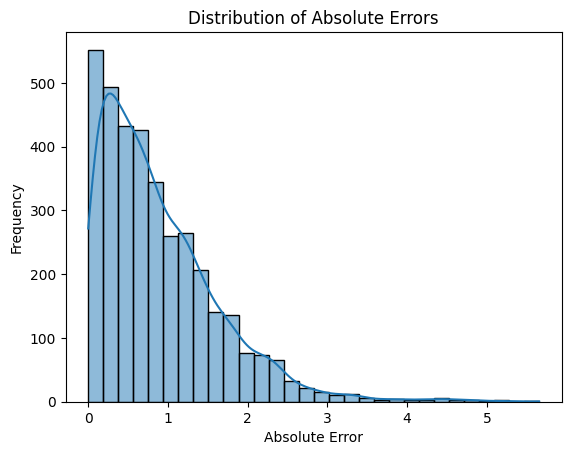

In [41]:
# Fit our best performing model on all the training data
#Compute the errors and a point estimate of the generalization error
X = df.drop(columns=['overall'])  # Features
y = df['overall']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with polynomial features and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
])

#Predict on the test set
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Compute the point estimate for the generalization error (MAE)
point_estimate = calculate_mae(len(y_test), y_test, y_pred)
print("Point Estimate (MAE):", point_estimate)

# Compute the confidence interval for the generalization error
# We have enough data in our test set that the appropirate t-quantile is close to 1.96 but you can use either 
# t- or z-distribution
# Assuming df is your DataFrame and has been defined
errors = y_test - y_pred
mean_error = np.mean(errors)
std_error = np.std(errors)
n = len(errors)

#Construct a confidence interval
confidence_interval = 1.96 * (std_error / np.sqrt(n))
lower_bound = mean_error - confidence_interval
upper_bound = mean_error + confidence_interval
print(f"95% Confidence Interval for Generalization Error: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Plot the distribution of absolute errors
absolute_errors = np.abs(errors)
sns.histplot(absolute_errors, bins=30, kde=True)
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()

**Answer a)**


**Answer b)**

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.